In [223]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [224]:
#os.chdir('C:\\Users\\loren\\xtreamassignment\\xtream-ai-assignment\\datasets\\italian-power-load')
load = 'load'
date = 'Date'

In [225]:
# create the function to retrieve the data and set the date in a format that I prefer to work with (instead of uploadinf the dataset directly)

def retrieve_data(source):


    df = pd.read_csv((f"{source}.csv"), parse_dates = [date])

    df[date] = pd.to_datetime(df[date], utc=True, infer_datetime_format=True)

    df[date] = df[date].dt.strftime('%Y-%m-%d')

    df[date] = df[date].drop_duplicates()

    #df = df.sort_values(by=[date])

    df = df.set_index(pd.DatetimeIndex(df[date]))

    df = df.drop(columns=['Date'])

    return df


In [226]:
df = retrieve_data(load)

# Task 1

## Data analysis and exploration

In [227]:
print('There are {} missing values or NaNs.'.format(df.isnull().values.sum()))

There are 0 missing values or NaNs.


In [228]:
# create the weekend function (it adds a column with dummy values: when it's sunday/saturday it's 1, otherwise 0)
def we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        
        if (weekend == 5) or (weekend == 6):
            df.loc[position, 'weekend'] = 1
        else:
            df.loc[position, 'weekend'] = 0
            

    #df.saturday = df.saturday.fillna(0)
    #df.sunday = df.sunday.fillna(0)

    return df

data = we_generation(df)

In [229]:
print('There are {} missing values or NaNs.'.format(data.isnull().values.sum()))

There are 0 missing values or NaNs.


In [230]:
data.Load.describe().round(3)

count       5882.000
mean      849407.248
std       125762.313
min       458751.849
25%       757587.250
50%       872072.500
75%       942405.736
max      1188554.000
Name: Load, dtype: float64

In [231]:
# Get all unique years in the dataset
years = data.index.year.unique()

# define the column of interest
energy = 'Load'

In [232]:
# Define a function to plot different types of time-series
def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=20)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=30)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=30)
    if label:
        ax.legend(fontsize=20)
    if title:
        ax.set_title(title, fontsize=25)
    return ax

C:\Users\loren\AppData\Local\Temp\ipykernel_9284\153070293.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


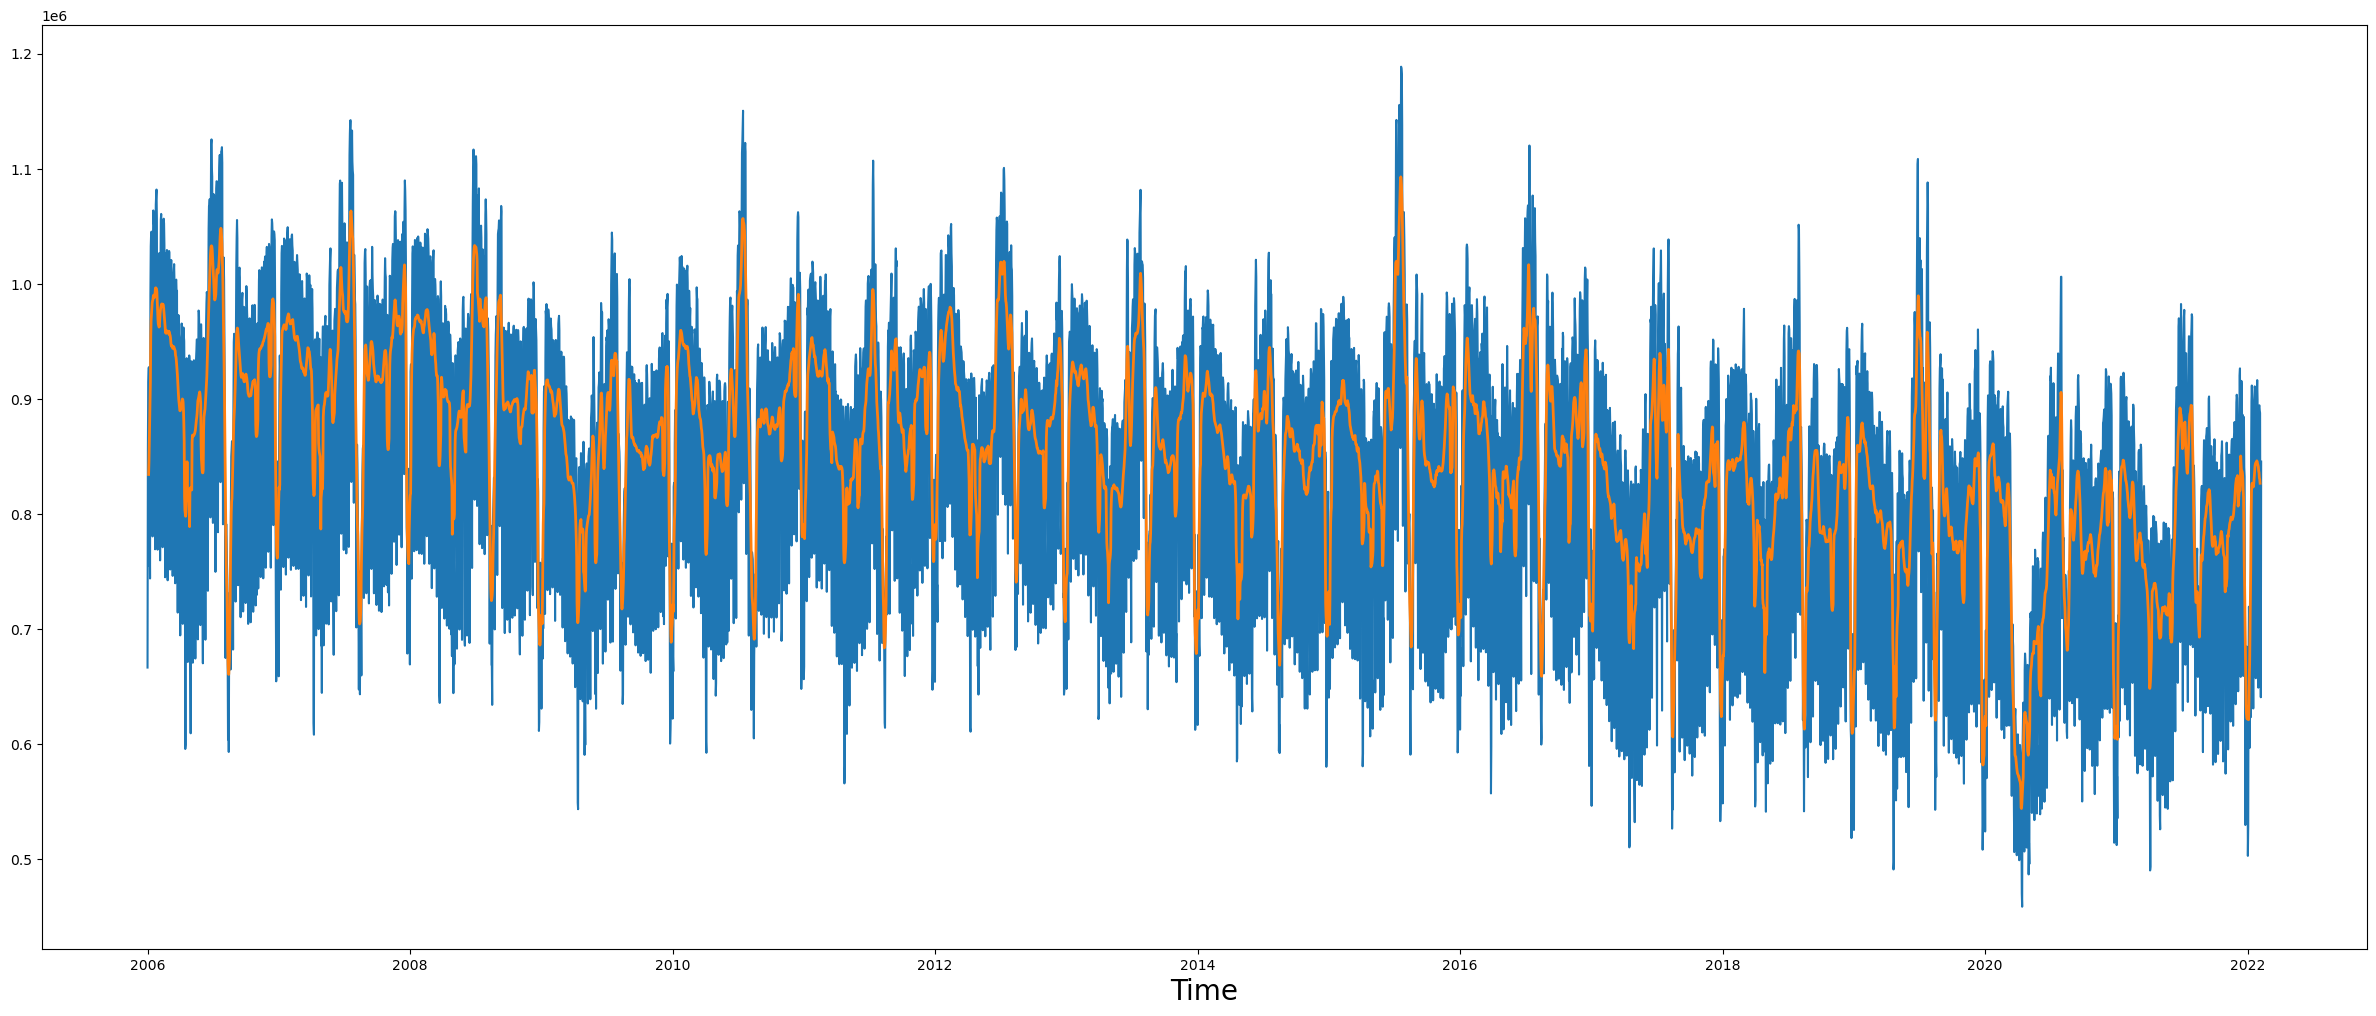

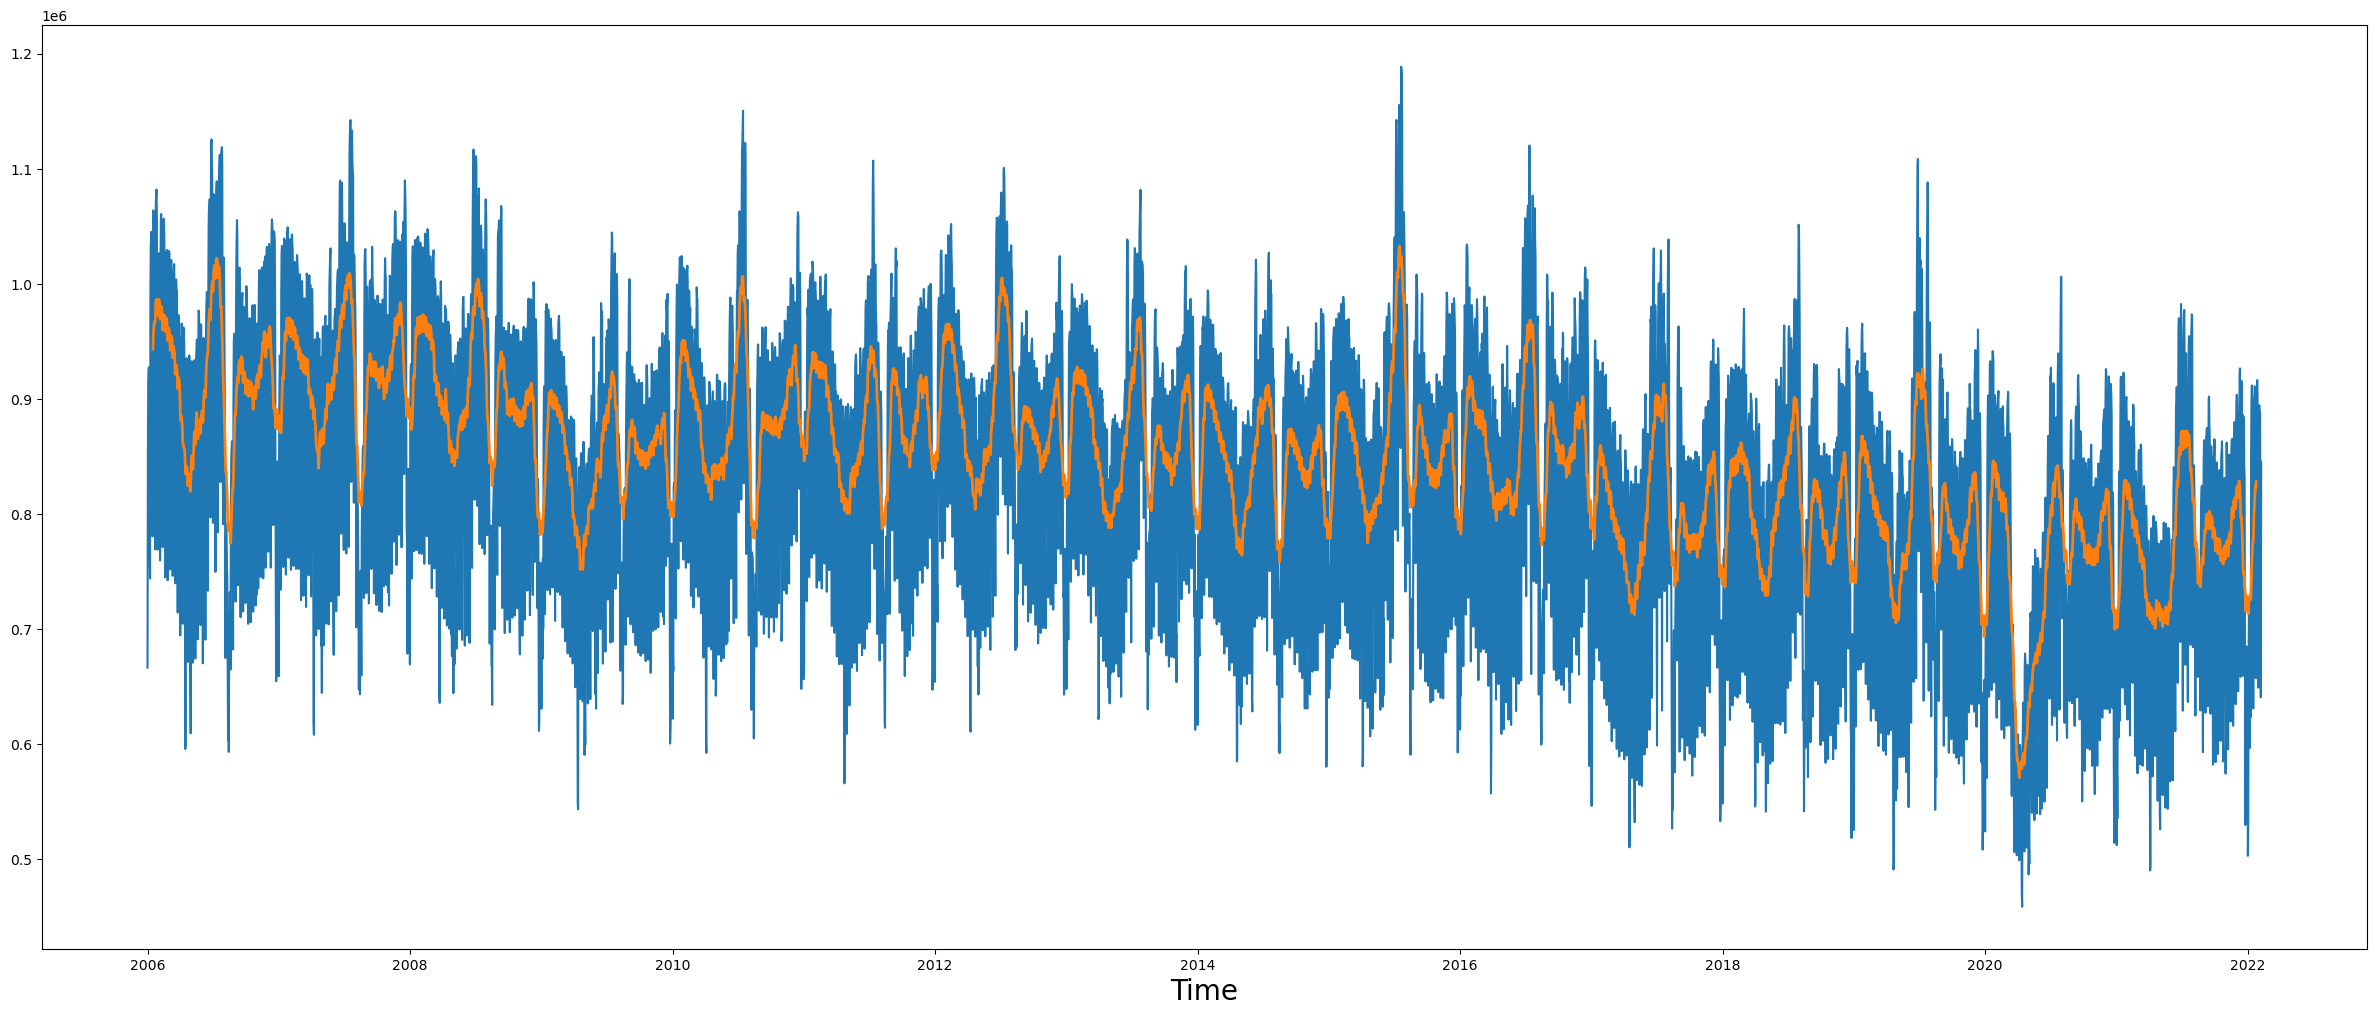

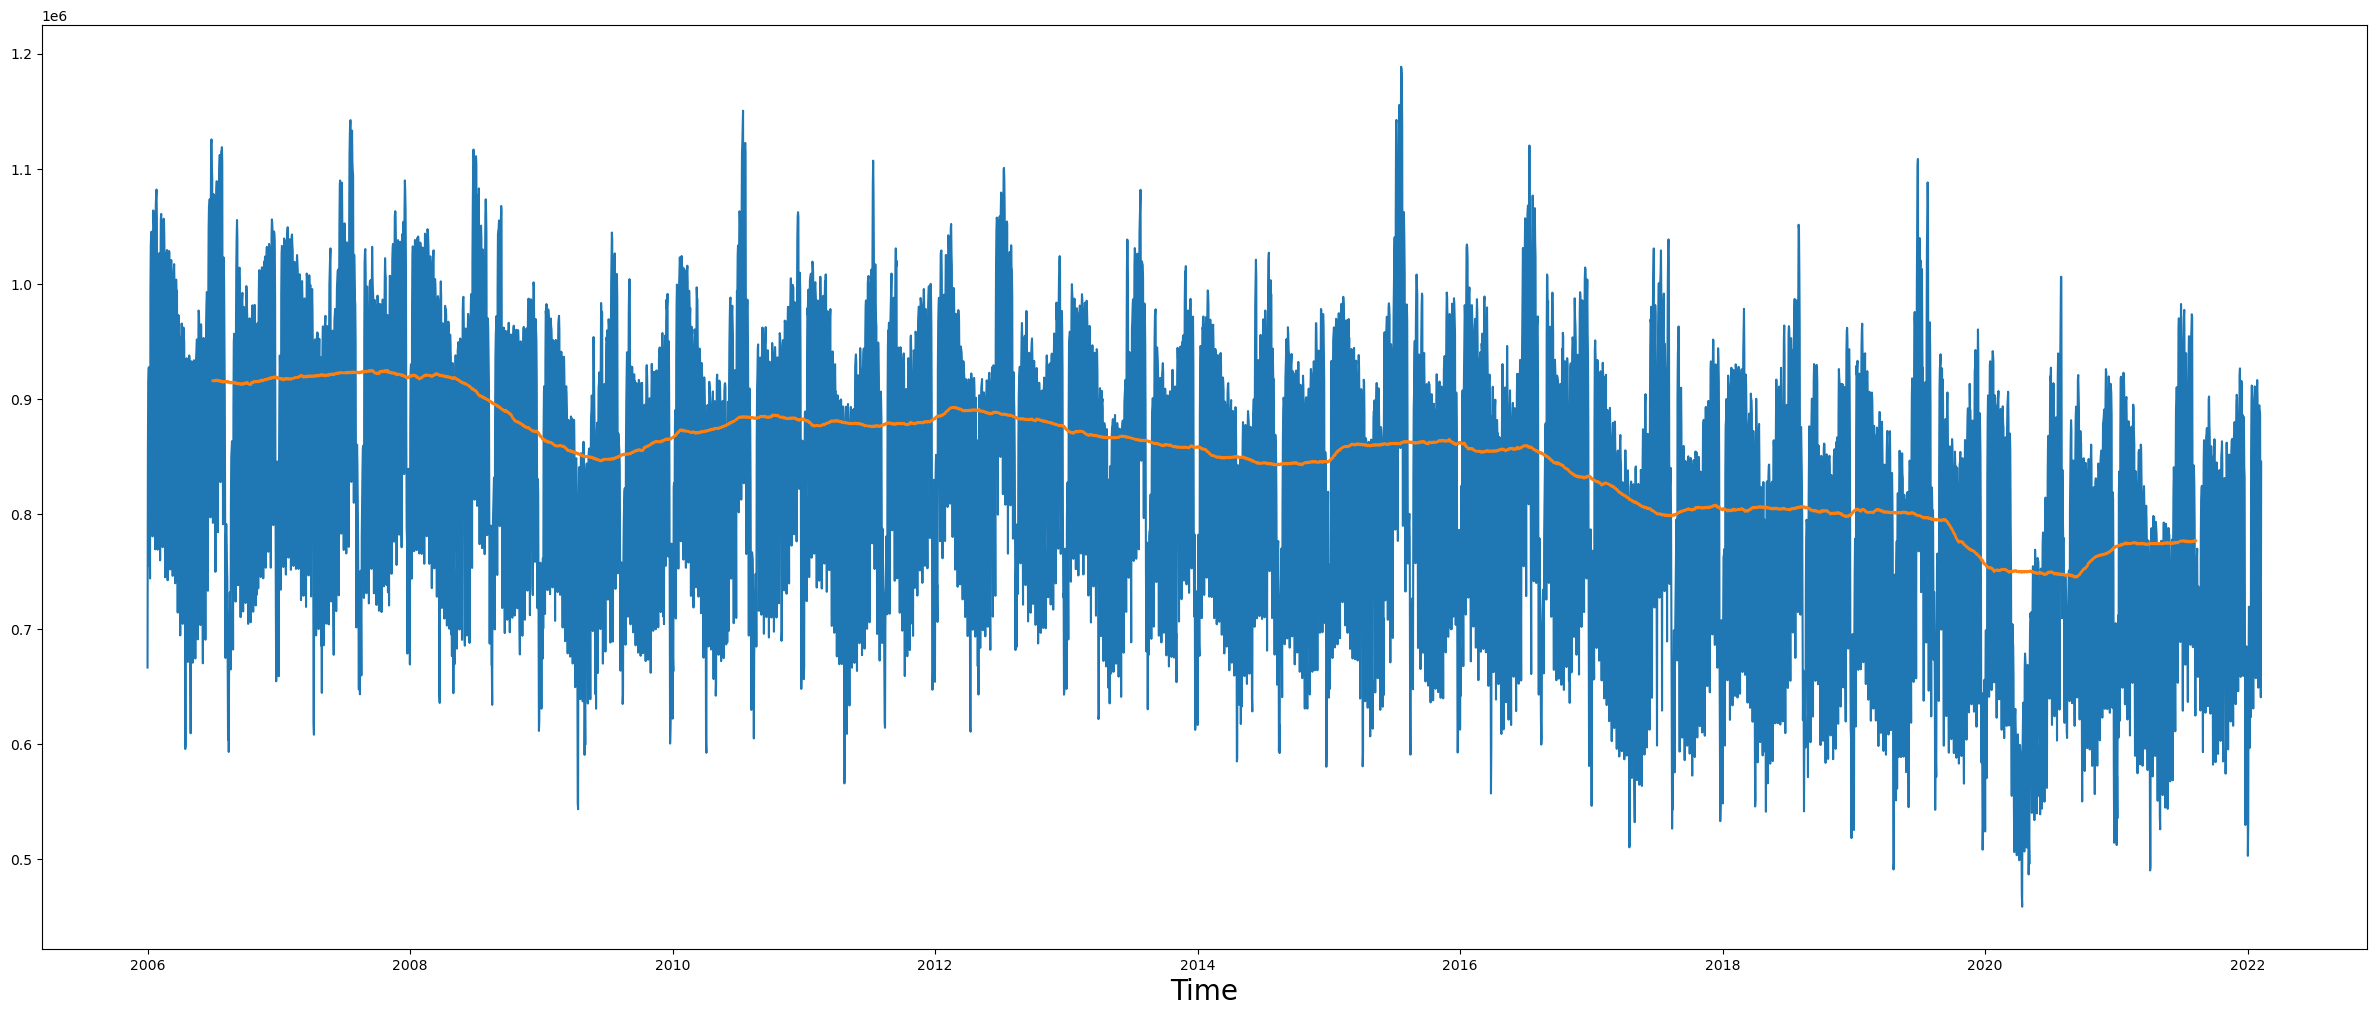

In [233]:
weekly = data[energy].rolling(7, center=True).mean()
monthly = data[energy].rolling(30, center=True).mean()
yearly = data[energy].rolling(365, center=True).mean()

rolls = [weekly, monthly, yearly]

for roll in rolls:
    ax = plot_series(data, energy)
    ax.plot(roll, linestyle='-', linewidth=2, label= f'{roll} rolling mean')

By plotting these graphs it is possible to see the rolling mean of the time series on weekly, monthly and yearly basis. The load consumption gradually decreases along the years, with a consistent drop during both 2008-2009 (the financial crisis years) and 2020-2021 (the years which were majorly hit by COVID-19)

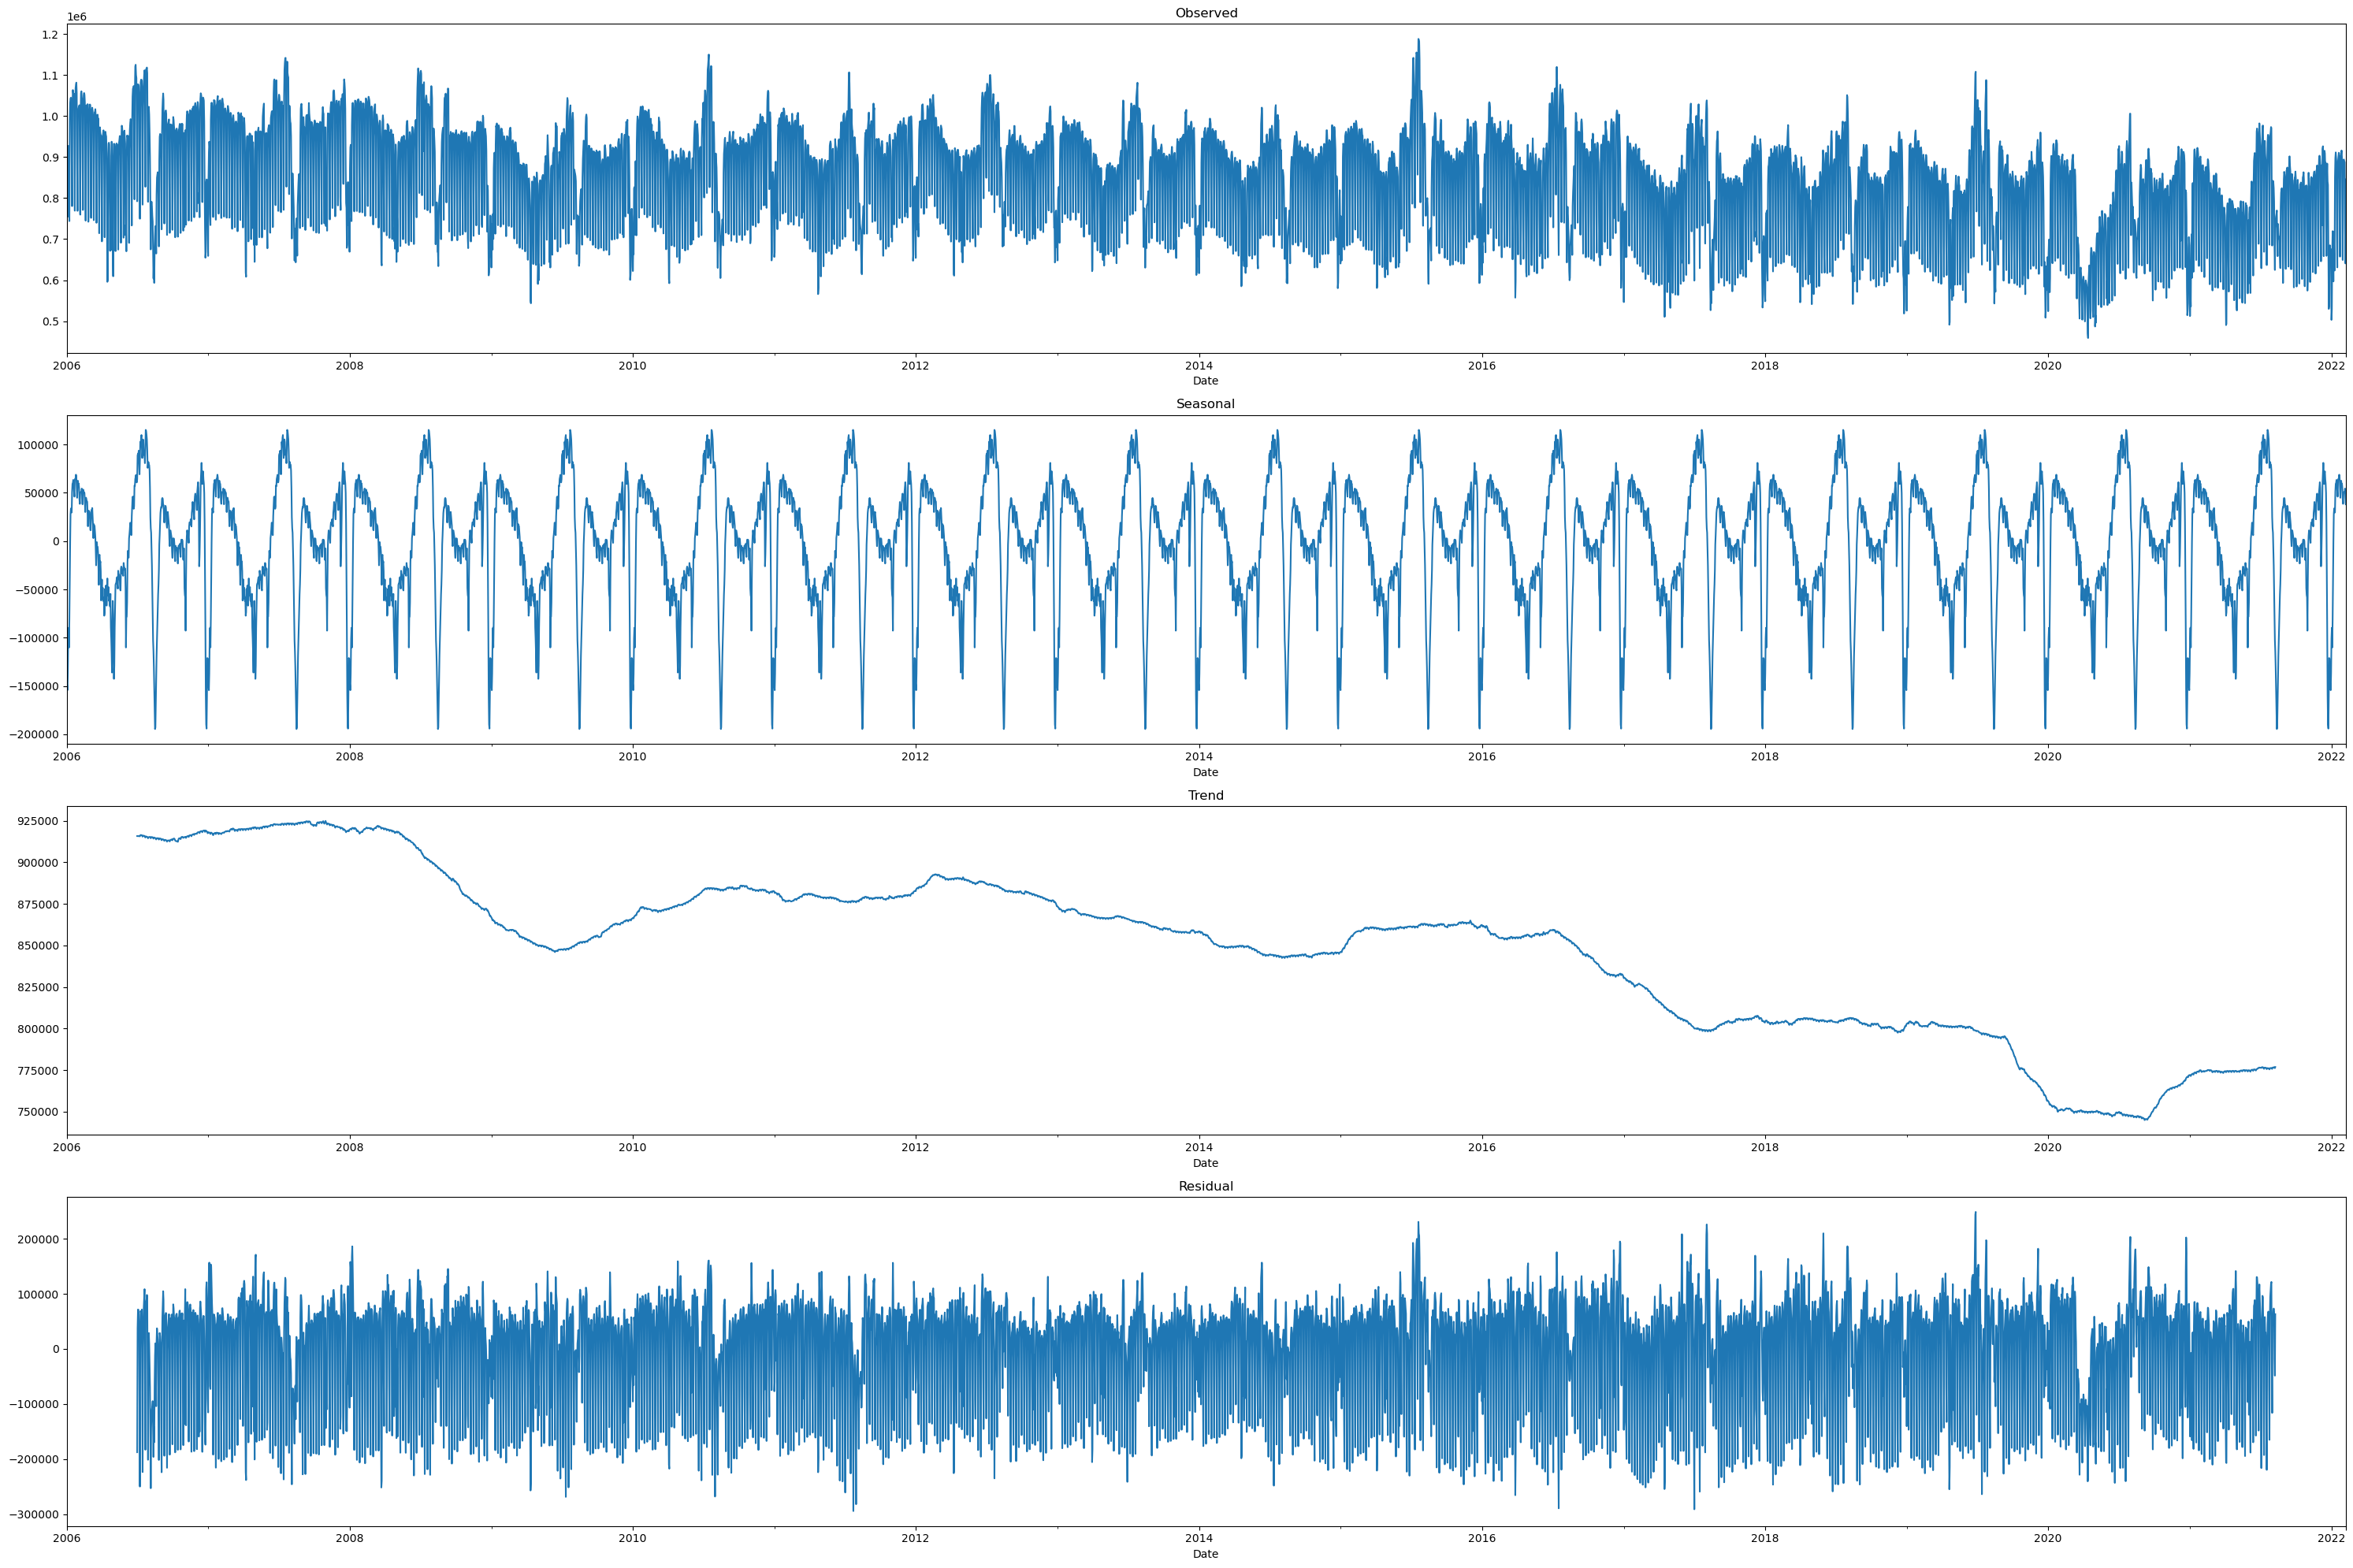

In [234]:
sd = sm.tsa.seasonal_decompose(data[energy], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
sd.observed.plot(ax=ax1, title='Observed')
sd.seasonal.plot(ax=ax2, title='Seasonal')
sd.trend.plot(ax=ax3, title='Trend')
sd.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

Here the seasonal decomposition is applied to the time series. I took as reference period 365 (yearly). The seasonal component shows dips during summer and the end of each year. This is probably due to the fact that in these periods less energy is consumed, either because during summer during summer many firms close and there's no need to consume energy for home heating and during Christmas holidays many firms close as well, reducing load consumption.

The time series presents a linear trend, which makes it non-stationary by definition.

c:\Users\loren\anaconda3\envs\global_packs\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


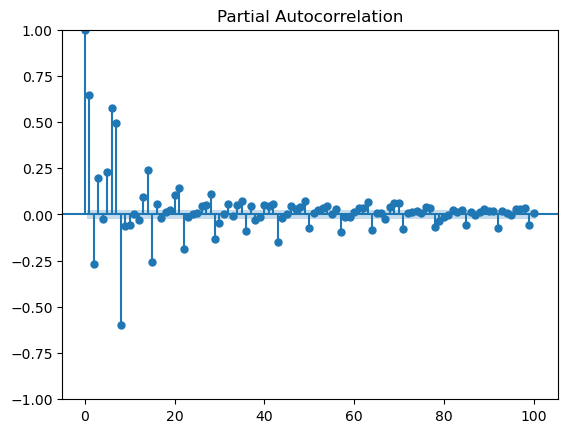

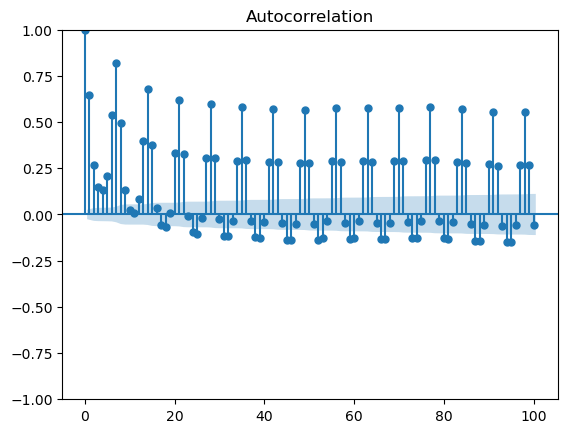

In [235]:
pacf = plot_pacf(data[energy], lags=100)

acf = plot_acf(data[energy], lags=100)

The partial autocorrelation with the past observations gradually disappears over time. The highest partial correlations can be found in the most recent past obervations, meaning that the present one shows a behaviour that can be related to them.
However, the autocorrelation doesn't disappear over time. Instead, it shows highly cyclical correlation with the past. This is another reason to believe the series is not stationary.

Load distribution plot


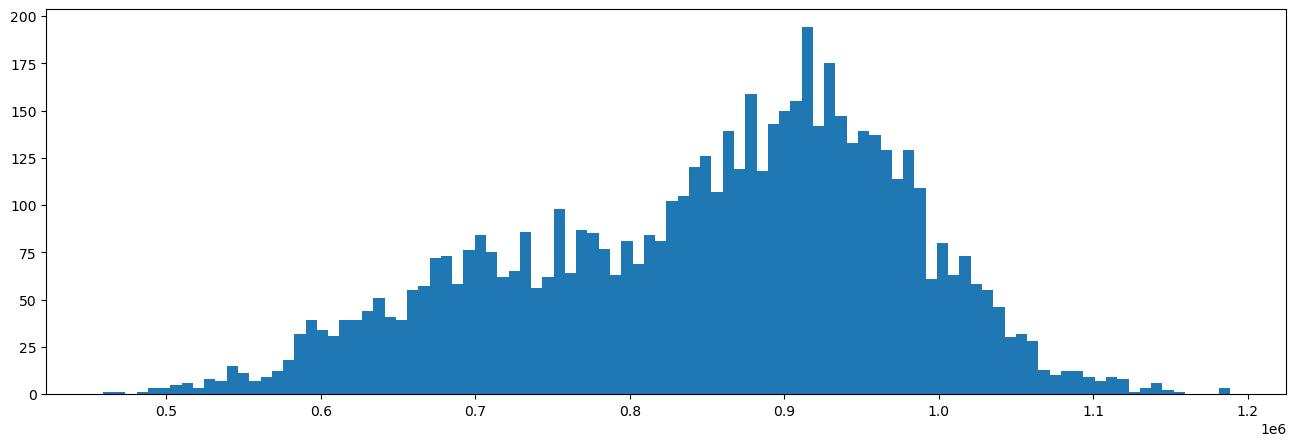

In [236]:
plt.figure(figsize=(16,5))
plt.hist(data[energy], bins=100)
print('Load distribution plot')
plt.show()

The distribution look like a Gamma distribution, thus no normality. Using classical statistical predictors may not be a good fit

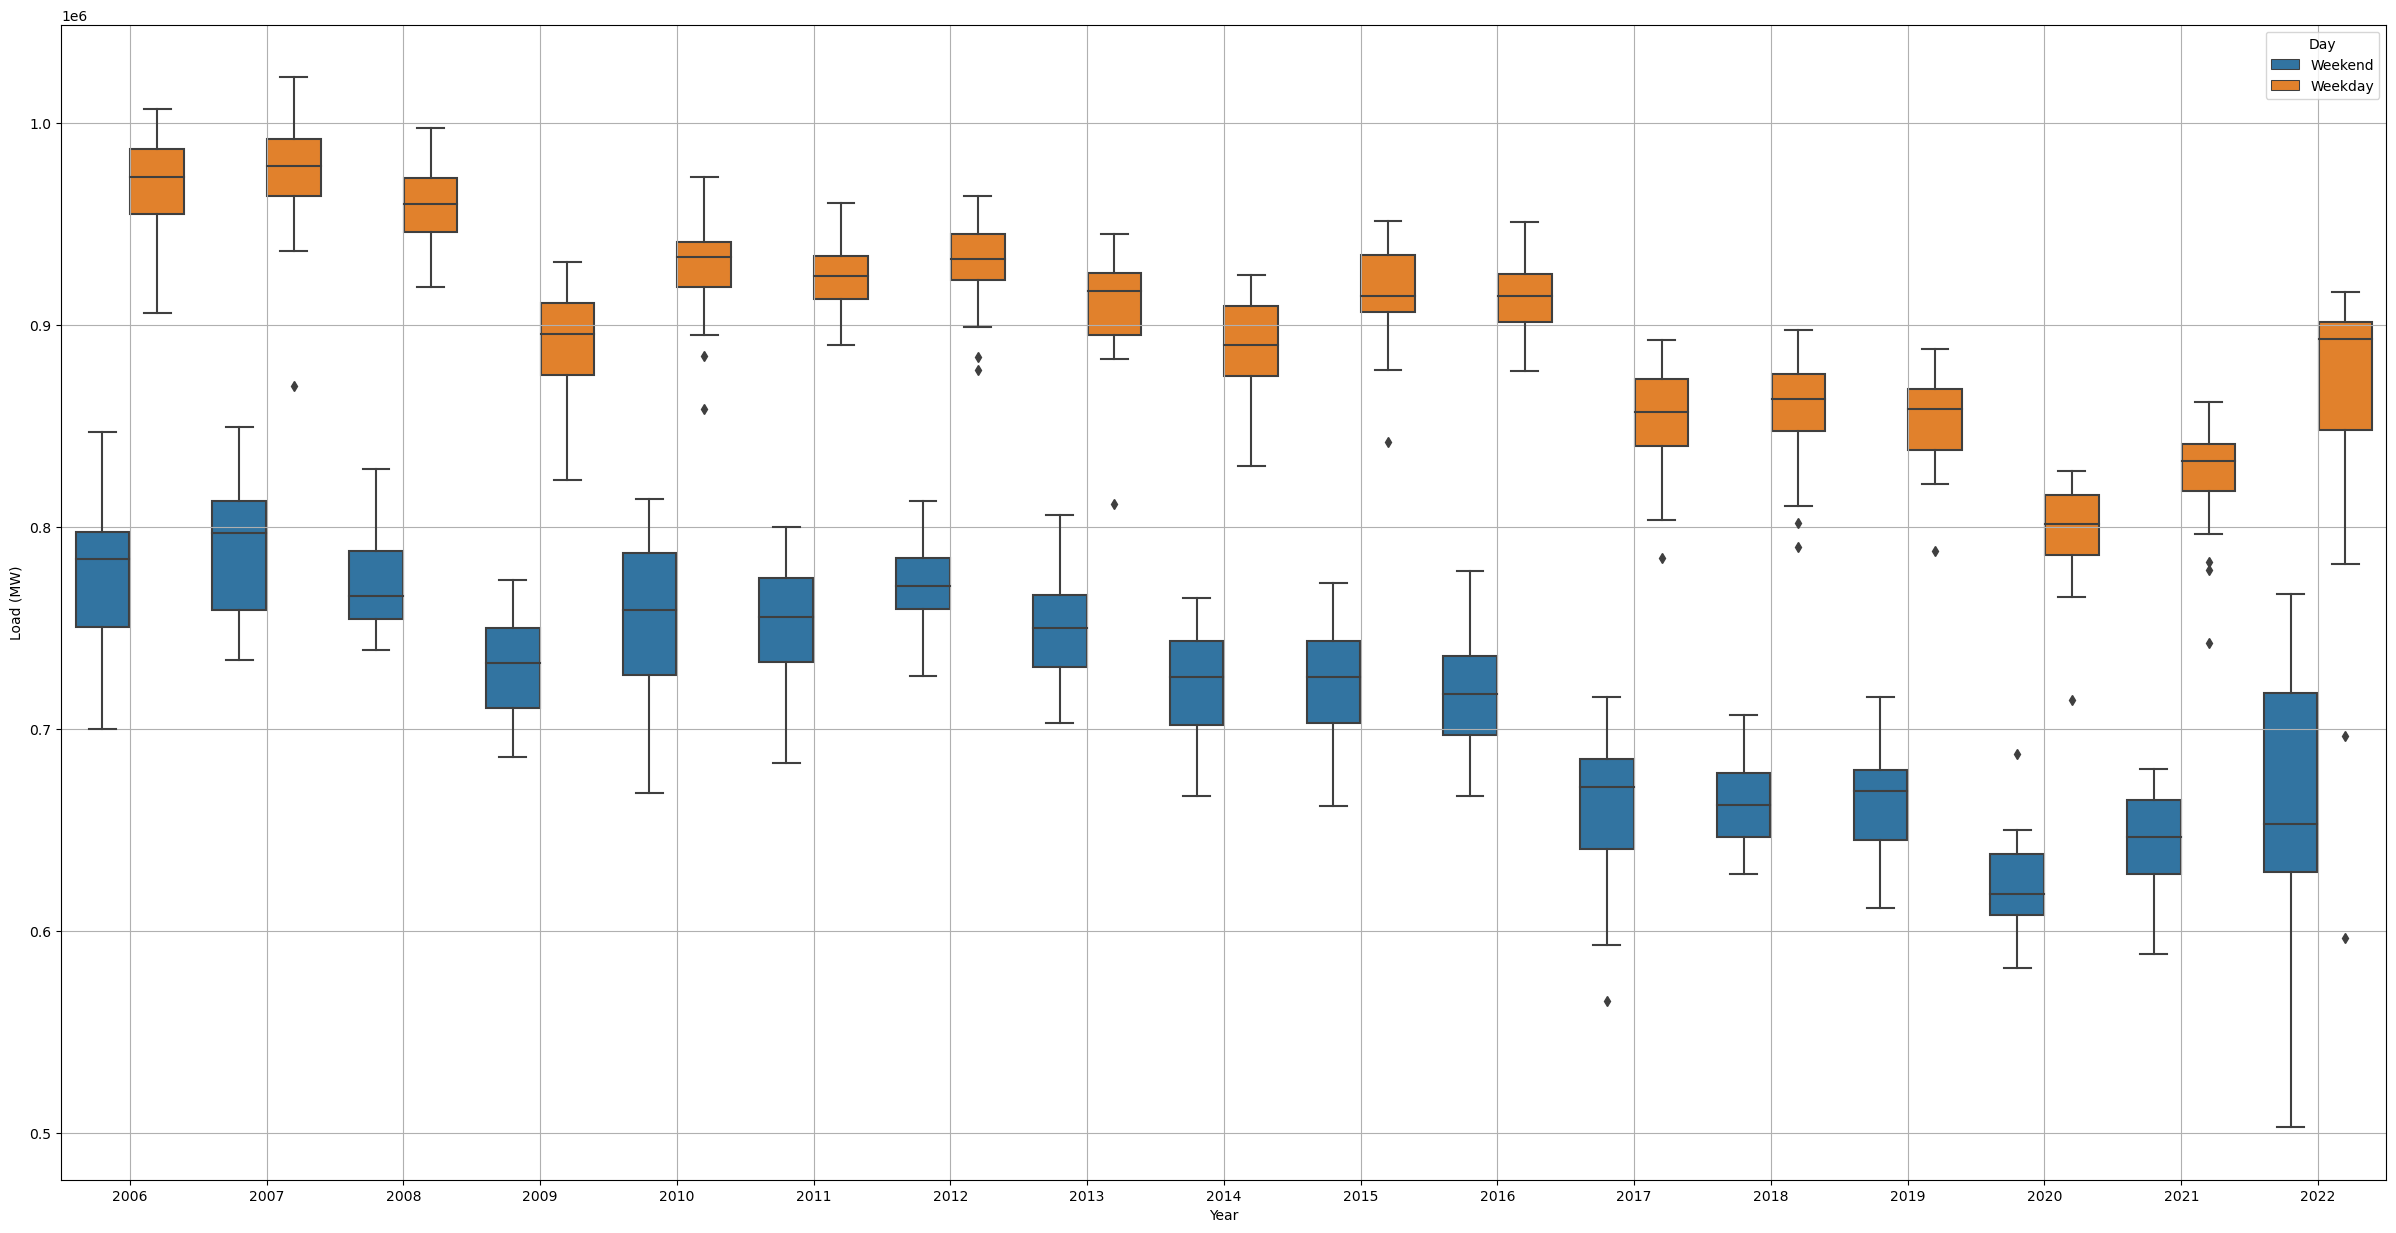

In [237]:
# Create an empty DataFrame to store combined data
combined_data = pd.DataFrame()

# Iterate through each year
for year in years:
    # Filter data for the current year
    year_data = data[data.index.year == year]
    
    # Separate weekend and weekday data
    weekend_data = year_data[year_data['weekend'] == 1]
    weekday_data = year_data[year_data['weekend'] == 0]
    
    # Calculate average hourly values for weekends and weekdays
    avg_weekend = weekend_data.groupby(weekend_data.index.day)[energy].mean().to_frame().assign(Day='Weekend', Year=year)
    avg_weekday = weekday_data.groupby(weekday_data.index.day)[energy].mean().to_frame().assign(Day='Weekday', Year=year)
    
    # Concatenate data from this year to the combined data
    combined_data = pd.concat([combined_data, avg_weekend, avg_weekday], axis=0)

# Create boxplot
plt.figure(figsize=(30,15))
sns.boxplot(data=combined_data, x='Year', y=energy, hue='Day')

#plt.title('Boxplot of Average Power Generated by Hour for All Years')
plt.xlabel('Year')
plt.ylabel('Load (MW)')
plt.grid(True)
#plt.legend(['Blue: weekend'],[], frameon=False)  # Add this line to not show the legend
plt.show()

Here the average load consumption for both weekdays and weekends for each year is presented. The load consumption is generally higher during weekdays (orange boxes), due to the fact that many economic activities are closed during weekends (blue boxes).  